## EXPERIMENTOS CON ICA

En este Notebook se hace una serie de experimentos con los parámetros del método ICA aplicado sobre la señal de EEG filtrada.

IMPORT MODULES

In [1]:
import mne
from TFG_utils import returnFiles, take_vmrk_files, take_vhdr_files, take_eeg_files, plot_freq_response, plot_PSD, plot_eeg_channel_corrected, plot_residual_PSD, plot_spots
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from sklearn.decomposition import PCA

In [2]:
print('MNE version:',mne.__version__)
#%matplotlib qt
verbose= True

MNE version: 0.20.7


#### COLLECTING DATA

In [3]:
foldername = 'EEG_folders'
EEG_files= returnFiles(foldername)

vmrk_files= take_vmrk_files(EEG_files)
vhdr_files= take_vhdr_files(EEG_files)
eeg_files= take_eeg_files(EEG_files)

i= 3 # Choosing EEG recording to use

vmrk_filename= vmrk_files[i]
vhdr_filename= vhdr_files[i]
eeg_filename= eeg_files[i]

raw_eeg = mne.io.read_raw_brainvision(vhdr_files[i],verbose=verbose).load_data(verbose=verbose).set_montage("standard_1020", verbose= verbose)
data,times= raw_eeg[:]
info= raw_eeg.info
fs= int(info['sfreq'])

#Selecting channel to represent:
ch = 2 #Channel F3
#ch = 28 #Channel F4
#ch = 3 #Channel F7
#ch = 29 #Channel F8

subject= eeg_filename[-8:-4]
print('Sujeto:',subject)
print('Canal:', info['ch_names'][ch])

Extracting parameters from EEG_folders\eeg_example_5\Neuromarketing2900.vhdr...
Setting channel info structure...
Reading 0 ... 252619  =      0.000 ...   505.238 secs...
Sujeto: 2900
Canal: F3


In [4]:
n_channels=31 # Number of channels to show in the plots


# TODOS picks=['Fp1','Fz','F3','F7','FT9','FC5','FC1','C3','T7','TP9','CP5','CP1','Pz','P3','P7','O1','Oz','O2','P4','P8','TP10','CP6','CP2','C4','T8','FT10','FC6','FC2','F4','F8','Fp2']
picks=['Fp1','Fz','F3','F7','FT9','FC5','FC1','T7','TP9','CP5','CP1','Pz','P3','P7','O1','Oz','O2','P4','P8','TP10','CP6','CP2','C4','T8','FT10','FC6','FC2','F4','F8','Fp2']

#### FILTERING DATA

In [5]:
f1,f2=(0.1,40)
eeg_filtered= raw_eeg.copy().set_montage("standard_1020", verbose= verbose)
eeg_filtered.filter(l_freq=f1, h_freq=f2, filter_length='auto', method='fir',fir_window='hamming', 
                      fir_design='firwin', verbose= verbose)
eeg_filtered.notch_filter([50,100,150], filter_length='auto', method='fir', fir_window='hamming', fir_design='firwin', verbose=None)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16501 samples (33.002 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



<RawBrainVision | Neuromarketing2900.eeg, 31 x 252620 (505.2 s), ~59.8 MB, data loaded>

# ICA

#### PCA

Cumulative variance calculation to estimate how many components we need to perform the ICA algorithm (n_components)

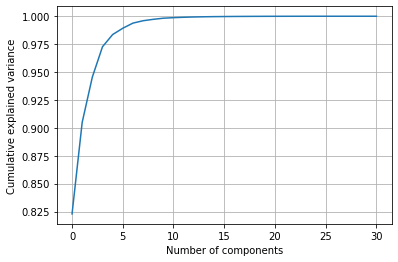

In [6]:
pca = PCA(n_components=None).fit(eeg_filtered['all'][0])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.show()

In [7]:
n_components=10

### 'FastICA' method

In [8]:
ica_fastica = mne.preprocessing.ICA(n_components=n_components, method="fastica", random_state=1)
ica_fastica.fit(eeg_filtered)

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 10 components
Fitting ICA took 3.9s.


<ICA  |  raw data decomposition, fit (fastica): 252620 samples, 10 components, channels used: "eeg">

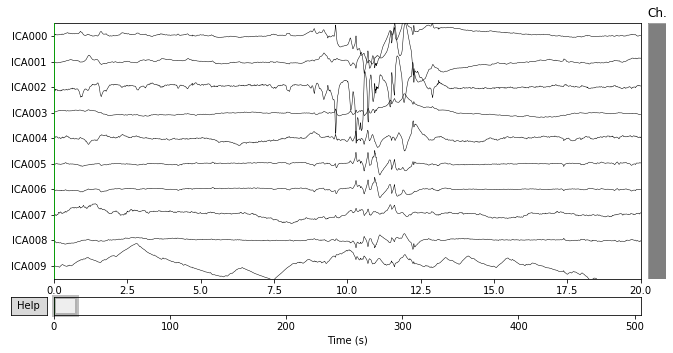

In [9]:
#%matplotlib qt
#%matplotlib notebook
ica_fastica.plot_sources(eeg_filtered)
plt.show()

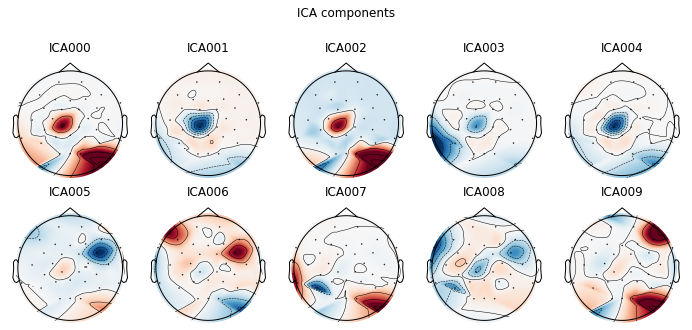

In [10]:
ica_fastica.plot_components()
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows
252 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
252 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
252 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
252 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


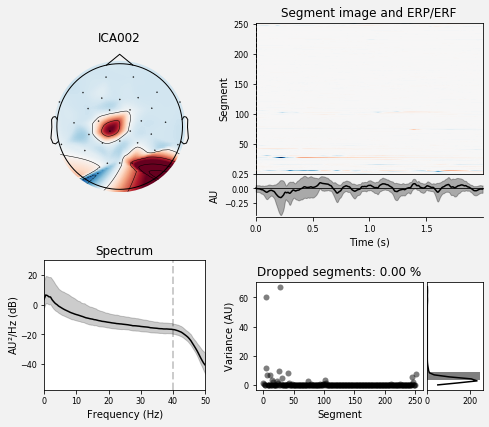

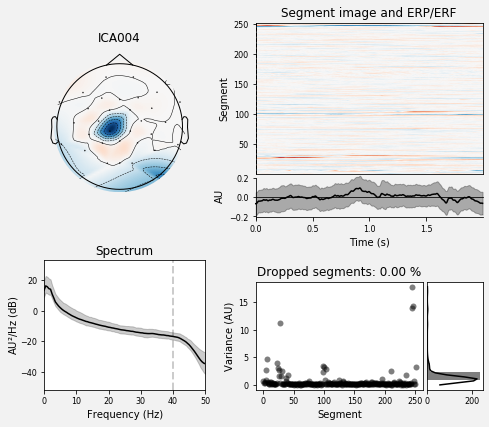

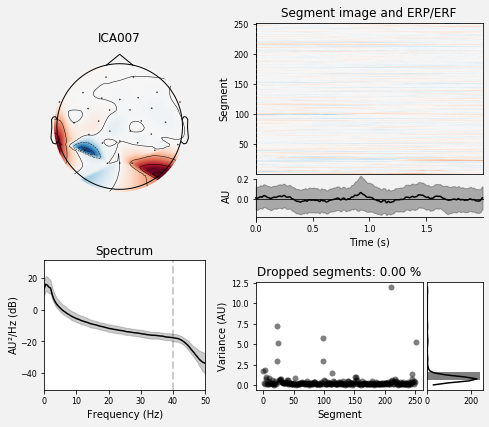

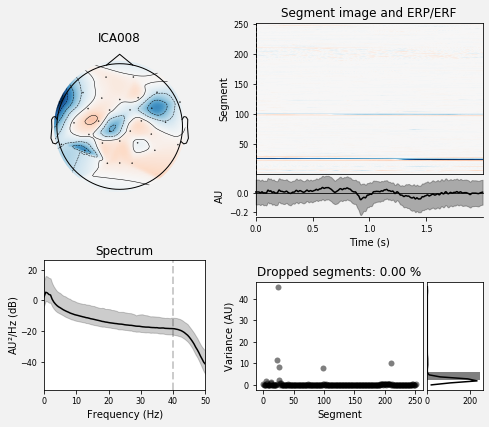

In [11]:
#%matplotlib qt
ica_fastica.plot_properties(eeg_filtered, picks=[2,4,7,8], dB=True, plot_std=True)
plt.show()

Transforming to ICA space (10 components)
Zeroing out 4 ICA components


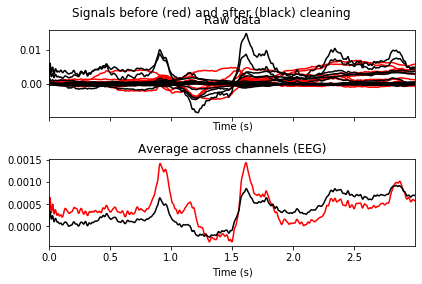

In [12]:
ica_fastica.plot_overlay(eeg_filtered, exclude=[2,4,7,8])
plt.show()

#### EXCLUDE

In [13]:
ica_fastica.exclude = [2,4,7,8]

In [14]:
raw_corrected = eeg_filtered.copy()
ica_fastica.apply(raw_corrected)

Transforming to ICA space (10 components)
Zeroing out 4 ICA components


<RawBrainVision | Neuromarketing2900.eeg, 31 x 252620 (505.2 s), ~59.8 MB, data loaded>

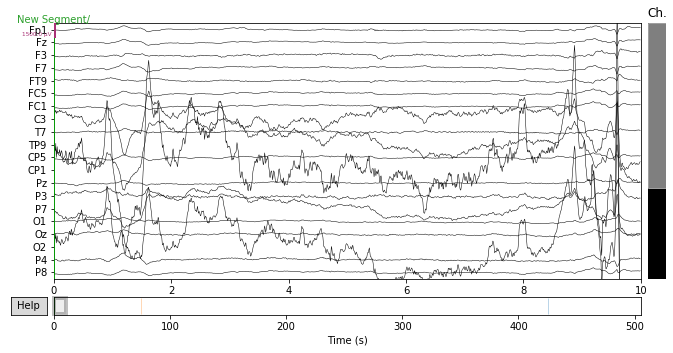

In [15]:
raw_corrected.plot(scalings={"eeg": 75e-5})
plt.show()

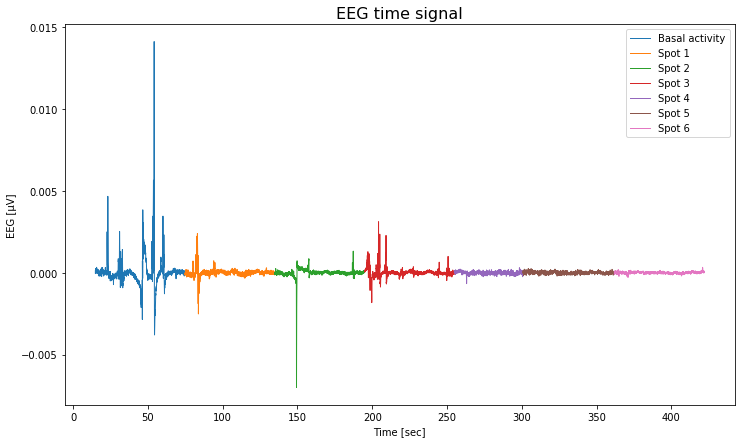

In [16]:
plot_spots(vmrk_filename,eeg_filtered,ch)

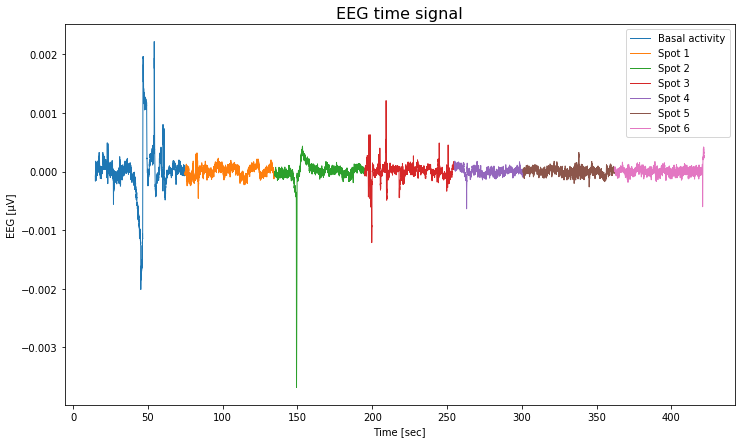

In [17]:
plot_spots(vmrk_filename,raw_corrected,ch)